#### Treatment Comparison
Compare barcoded subpopulations of idling and untreated (control) SKMEL5 cells by their cell-cell distance


In [1]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# reload functions when editing file
import sys
del sys.modules['utilityfunctions']
from utilityfunctions import *

Read in data files and associate barcodes with RNA counts

In [2]:
%%time
# untreated control BRAF melanoma cell line (SKMEL5)
U = RNA_counts.from_file(datafile='untreated/untreated_raw.csv.gz', cells_axis=1, barcodefile='untreated/Untreated_LineageBC_cellBC.csv')
# treated, idling BRAF melanoma cell line (SKMEL5)
I = RNA_counts.from_file(datafile='idling/treated_raw.csv.gz', cells_axis=1, barcodefile='idling/Treated_LineageBC_cellBC.csv')

CPU times: user 35.2 s, sys: 6.68 s, total: 41.9 s
Wall time: 43.8 s


In [3]:
top30 = list(range(1,31))

Using top barcodes in __Untreated__ set, look at abundance in __Idling__ set

In [8]:
min(U.barcode_counts(IDs=U.top_barcodes(top30)))

22

In [9]:
min(I.barcode_counts(IDs=U.top_barcodes(top30)))

10

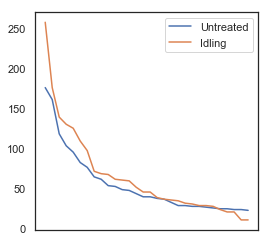

In [10]:
# plot abundance of barcodes to use for distance calcs
plt.figure(figsize=(4,4))
U.barcode_counts(IDs=U.top_barcodes(top30)).plot(label='Untreated', legend=True)
I.barcode_counts(IDs=U.top_barcodes(top30)).plot(label='Idling', legend=True)
plt.show()

In [11]:
# get list of codes to use throughout the rest of analysis
selected_codes = U.top_barcodes(top30)

---
### PCA
100 component on arcsinh-transformed counts data

Perform PCA on each dataset and plot selected barcodes

In [12]:
%%time 
# perform PCA with 100 components on untreated cells, arcsinh-normalized
U_PCA = fcc_PCA(matrix=U.arcsinh_norm(), barcodes=U.barcodes, n_components=100)

CPU times: user 13.7 s, sys: 2.91 s, total: 16.6 s
Wall time: 11.9 s


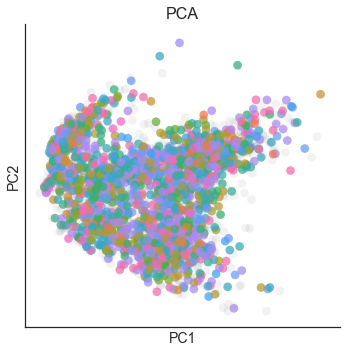

In [13]:
U_PCA.plot_barcodes(ranks=selected_codes)

In [14]:
%%time 
# perform PCA with 100 components on idling cells, arcsinh-normalized
I_PCA = fcc_PCA(matrix=I.arcsinh_norm(), barcodes=I.barcodes, n_components=100)

CPU times: user 17 s, sys: 3.95 s, total: 20.9 s
Wall time: 15.4 s


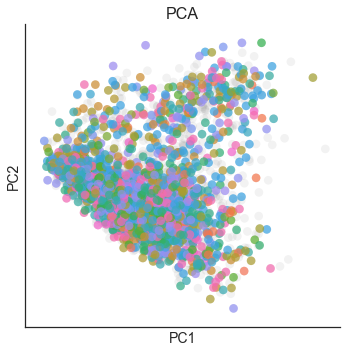

In [15]:
I_PCA.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

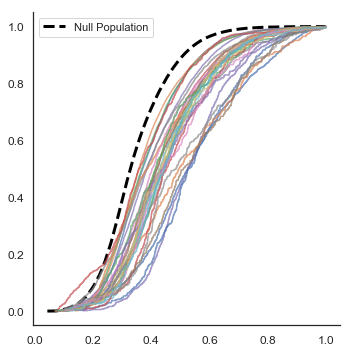

CPU times: user 47.3 s, sys: 1.92 s, total: 49.3 s
Wall time: 49.6 s


In [16]:
%%time
U_out = compare_barcode_distances(obj=U_PCA, barcodes=selected_codes)

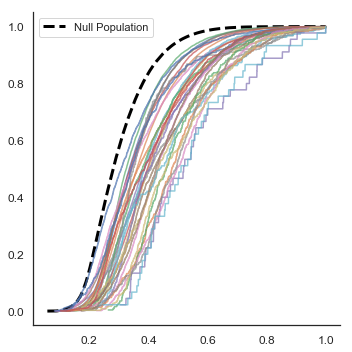

CPU times: user 1min 14s, sys: 3.7 s, total: 1min 17s
Wall time: 1min 18s


In [17]:
%%time
I_out = compare_barcode_distances(obj=I_PCA, barcodes=selected_codes)

---
Now, we want to generate statistical confidence in the "noise" or tolerance for EMD using random subsampling for calculation of EMD from the null population.

Need to correct for number of cells in each barcode, and bias in EMD compared to whole population. The acceptance criteria line should be fit to number of cells and have some growing uncertainty around it.

In [18]:
U.barcode_counts(selected_codes)

CTGAGTCAGAGTGACACACT    176
CTGAGAGTGAGTCTGTCAGT    161
CTGAGTCACTCACTGAGTGT    118
CTGAGTGTGAGAGTGTGTGT    103
CTGACAGTGTCACACAGTGA    95 
CTGAGAGACTCTGTGACTGA    82 
CTGAGACTCAGACAGACACT    76 
CTGACTGTCAGACAGAGTGA    64 
CTGAGTCAGTCACACTCTGT    61 
CTGACTGTCTGTCAGTGTGT    53 
CTGACAGTGTGTCAGTCTCT    52 
CTGAGAGTCACTGAGTGTGT    48 
CTGAGTGTCACTCTCTCAGA    47 
CTGACAGACACTCTCAGTCT    43 
CTGACAGTCACACTGACTCA    39 
CTGAGTGTGACTGTGTGTGA    39 
CTGACTGTGTGTCAGTGTGA    37 
CTGACTGAGAGTGAGTCACA    36 
CTGAGAGTGACAGACTCAGT    32 
CTGACACACTCTCACTGACA    28 
CTGACTCTGTCACAGAGTGA    28 
CTGACTCAGTCTGTCTGTCA    27 
CTGAGTGTGAGTCTGTGACA    27 
CTGACTGACTGTGTCTGTGA    26 
CTGACAGTCAGTCAGTGTGA    25 
CTGACTGAGAGACTGAGACA    24 
CTGACACACTGTGACTGTGT    24 
CTGAGTGTCACACACACTGA    23 
CTGACTGTCTGAGAGTCACA    23 
CTGAGAGACTGTCAGAGTCA    22 
Name: Barcode, dtype: int64

In [19]:
%%time
# range of top 30 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
# 30 replicates at each 20-cell interval 
U_curve = cell_bias_curve(obj=U_PCA, pop_sizes=np.arange(20, 181, 20), iter=30)

CPU times: user 6min 16s, sys: 9.04 s, total: 6min 25s
Wall time: 6min 26s


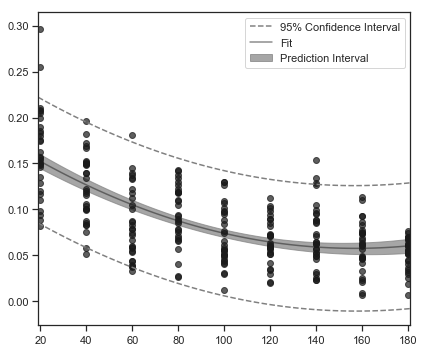

In [21]:
# build regression of cell titration to define acceptance criteria
U_p, U_pi, U_ci = easy_regression(x=U_curve.melt(id_vars='n_cells')['n_cells'], y=U_curve.melt(id_vars='n_cells')['value'], deg=2)

---
Do the same as above for __Idling__ dataset

In [22]:
I.barcode_counts(selected_codes)

CTGAGAGTGAGTCTGTCAGT    258
CTGAGTCAGAGTGACACACT    176
CTGACAGACACTCTCAGTCT    139
CTGAGTGTGAGAGTGTGTGT    130
CTGAGTCACTCACTGAGTGT    125
CTGACAGTGTCACACAGTGA    109
CTGAGAGACTCTGTGACTGA    97 
CTGAGAGTCACTGAGTGTGT    71 
CTGAGTCAGTCACACTCTGT    68 
CTGAGACTCAGACAGACACT    67 
CTGACAGTGTGTCAGTCTCT    61 
CTGACTGTGTGTCAGTGTGA    60 
CTGACTGTCTGTCAGTGTGT    59 
CTGAGTGTGACTGTGTGTGA    51 
CTGAGTGTCACTCTCTCAGA    45 
CTGACTGAGAGACTGAGACA    45 
CTGACTGACTGTGTCTGTGA    38 
CTGACTGTCAGACAGAGTGA    36 
CTGACACACTGTGACTGTGT    35 
CTGACTCTGTCACAGAGTGA    34 
CTGACAGTCACACTGACTCA    31 
CTGAGAGTGACAGACTCAGT    30 
CTGACTCAGTCTGTCTGTCA    28 
CTGAGTGTCACACACACTGA    28 
CTGACTGTCTGAGAGTCACA    27 
CTGAGTGTGAGTCTGTGACA    23 
CTGACACACTCTCACTGACA    20 
CTGACTGAGAGTGAGTCACA    20 
CTGAGAGACTGTCAGAGTCA    10 
CTGACAGTCAGTCAGTGTGA    10 
Name: Barcode, dtype: int64

In [23]:
%%time
# range of top 30 barcodes in idling dataset is 10 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
# 20 replicates at each 10-cell interval 
I_curve = cell_bias_curve(obj=I_PCA, pop_sizes=np.arange(10, 261, 10), iter=20)

CPU times: user 18min 39s, sys: 32.5 s, total: 19min 11s
Wall time: 19min 14s


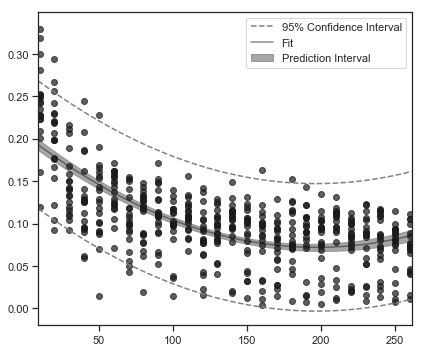

In [24]:
# build regression of cell titration to define acceptance criteria
I_p, I_pi, I_ci = easy_regression(x=I_curve.melt(id_vars='n_cells')['n_cells'], y=I_curve.melt(id_vars='n_cells')['value'], deg=2)

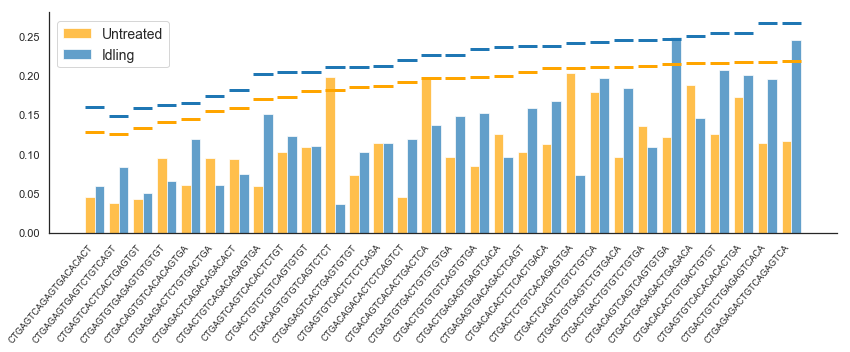

In [25]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc=[0.01,0.75],fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()


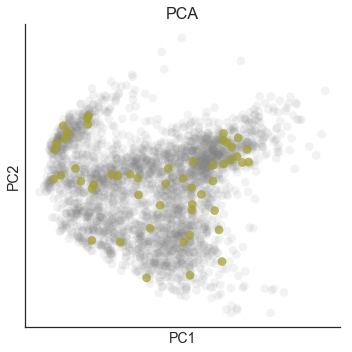

In [26]:
U_PCA.plot_barcodes(ranks=[selected_codes[10]])

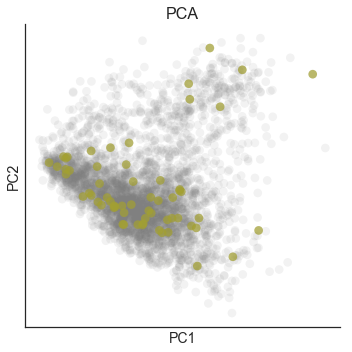

In [27]:
I_PCA.plot_barcodes(ranks=[selected_codes[10]])

---
#### t-SNE
Let's perform a t-SNE on the PCA results to reduce the data to two dimensions so the distances aren't in 100-component PCA space.

In [29]:
%%time 
# perform t-SNE on untreated cells, arcsinh-normalized and 100-component PCA primed
U_tSNE = fcc_tSNE(matrix=U_PCA.results, barcodes=U_PCA.barcodes, perplexity=30)

CPU times: user 22.1 s, sys: 1.14 s, total: 23.2 s
Wall time: 23.6 s


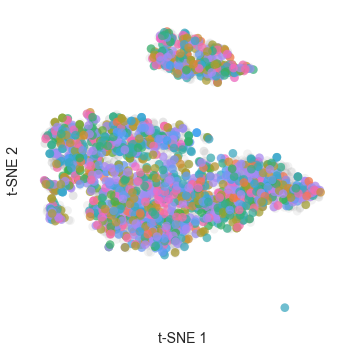

In [30]:
U_tSNE.plot_barcodes(ranks=selected_codes)

In [31]:
%%time 
# perform t-SNE on idling cells, arcsinh-normalized and 100-component PCA primed
I_tSNE = fcc_tSNE(matrix=I_PCA.results, barcodes=I_PCA.barcodes, perplexity=30)

CPU times: user 25.7 s, sys: 1.38 s, total: 27 s
Wall time: 27.1 s


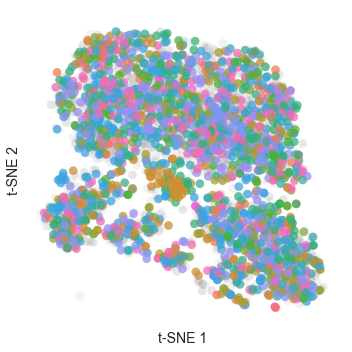

In [32]:
I_tSNE.plot_barcodes(selected_codes)

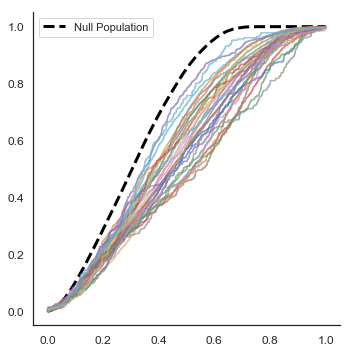

CPU times: user 45.2 s, sys: 1.57 s, total: 46.8 s
Wall time: 46.7 s


In [33]:
%%time
U_tSNE_out = compare_barcode_distances(obj=U_tSNE, barcodes=selected_codes)

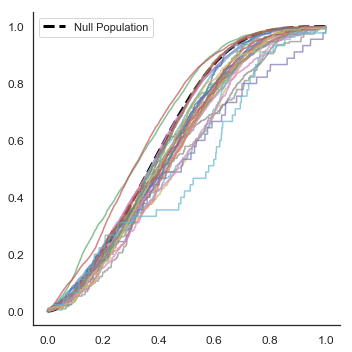

CPU times: user 1min 10s, sys: 2.37 s, total: 1min 12s
Wall time: 1min 12s


In [34]:
%%time
I_tSNE_out = compare_barcode_distances(obj=I_tSNE, barcodes=selected_codes)

In [35]:
%%time
# range of top 30 barcodes in untreated dataset is 20 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 
# 30 replicates at each 20-cell interval 
U_tSNE_curve = cell_bias_curve(obj=U_tSNE, pop_sizes=np.arange(20, 181, 20), iter=30)

CPU times: user 6min 24s, sys: 9.93 s, total: 6min 33s
Wall time: 6min 40s


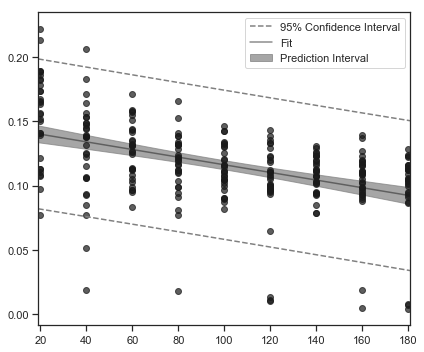

In [42]:
# build regression of cell titration to define acceptance criteria
U_tSNE_p, U_tSNE_pi, U_tSNE_ci = easy_regression(x=U_tSNE_curve.melt(id_vars='n_cells')['n_cells'], y=U_tSNE_curve.melt(id_vars='n_cells')['value'], deg=1)

---
Do the same as above for __Idling__ dataset

In [37]:
%%time
# range of top 30 barcodes in idling dataset is 10 to 260 cells. create 'standard curve' of n_cells to determine noise threshold. 
# 20 replicates at each 10-cell interval 
I_tSNE_curve = cell_bias_curve(obj=I_tSNE, pop_sizes=np.arange(10, 261, 10), iter=20)

CPU times: user 19min 5s, sys: 26.4 s, total: 19min 31s
Wall time: 19min 40s


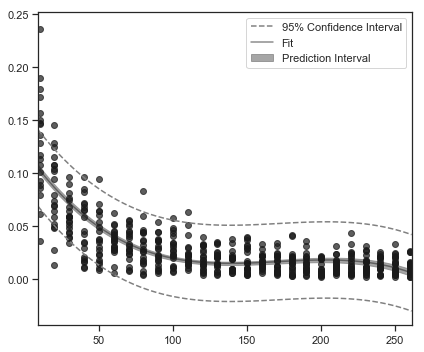

In [39]:
# build regression of cell titration to define acceptance criteria
I_tSNE_p, I_tSNE_pi, I_tSNE_ci = easy_regression(x=I_tSNE_curve.melt(id_vars='n_cells')['n_cells'], y=I_tSNE_curve.melt(id_vars='n_cells')['value'], deg=3)

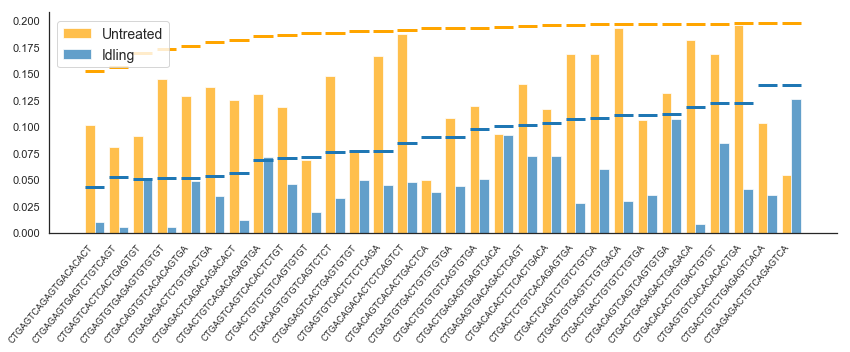

In [43]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_tSNE_out.code, height=U_tSNE_out.EMD, align='edge', width=-0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_tSNE_out.code, height=I_tSNE_out.EMD, align='edge', width=0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_tSNE_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_tSNE_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_tSNE_curve.melt(id_vars='n_cells')['value'],
                                  p=U_tSNE_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_tSNE_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_tSNE_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_tSNE_curve.melt(id_vars='n_cells')['value'],
                                  p=I_tSNE_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.legend(loc=[0.01,0.75],fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
### Feature Selection
Prime t-SNE with [NVR feature selection](https://github.com/KenLauLab/NVR)

In [ ]:
U_nvr = U.nvr_select(counts_obj=U)

In [ ]:
%%time 
U_nvr_PCA = fcc_PCA(matrix=U_nvr.counts, barcodes=U.barcodes, n_components=10)
U_nvr_PCA.plot()
U_nvr_PCA.plot_barcodes(selected_codes)

In [ ]:
%%time 
U_nvr_tSNE = fcc_FItSNE(matrix=U_nvr_PCA.results, barcodes=U_nvr_PCA.barcodes, perplexity=30)
U_nvr_tSNE.plot()
U_nvr_tSNE.plot_barcodes(selected_codes)

Now, for each of our *selected_codes*, calculate a distance matrix from the null (whole population) within each group, and plot.

In [ ]:
%%time
pre = U_nvr_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_nvr_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_nvr_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_nvr_tSNE.results[np.random.choice(U_FItSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

In [ ]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

NVR doesn't do a great job with this dataset, let's try a brute-force variable genes selection

---
#### Feature Selection (Variable Genes)
NVR didn't seem to work very well

In [23]:
U_vg = U.var_select(counts_obj=U, n_features=200) # select 200 most variable genes

In [ ]:
compare_distance_dist(pre=U_vg.distance_matrix(transform='arcsinh', ranks='all'), post=U_vg.distance_matrix(transform='arcsinh', ranks=selected_codes[2]))

In [ ]:
%time U_vg_tSNE = fcc_FItSNE(matrix=U_vg.counts, barcodes=U_vg.barcodes, perplexity=30)

In [ ]:
U_vg_tSNE.plot() 
U_vg_tSNE.plot_barcodes(top20)

In [ ]:
%%time
pre = U_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_vg_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_vg_tSNE.results[np.random.choice(U_vg_tSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

In [ ]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

---
Do same thing for __Idling__ dataset

In [ ]:
I_vg = I.var_select(counts_obj=I, n_features=200) # select 200 most variable genes

In [ ]:
compare_distance_dist(pre=I_vg.distance_matrix(transform='arcsinh', ranks='all'), post=I_vg.distance_matrix(transform='arcsinh', ranks=selected_codes[2]))

In [ ]:
%time I_vg_tSNE = fcc_FItSNE(matrix=I_vg.counts, barcodes=I_vg.barcodes, perplexity=30)

In [ ]:
I_vg_tSNE.plot() 
I_vg_tSNE.plot_barcodes(top20)

In [ ]:
%%time
pre = I_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_vg_tSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_vg_tSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        I_rand = I_vg_tSNE.results[np.random.choice(I_vg_tSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(I_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

In [ ]:
I_p, I_pi, I_ci = easy_regression(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

In [ ]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.title('Significant Distance - Feature Selected t-SNE')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

---
#### Feature Selection (Variable Genes) & PCA

In [ ]:
%%time 
U_vg_PCA = fcc_PCA(matrix=U_vg.counts, barcodes=U_vg.barcodes, n_components=45)
U_vg_PCA.plot()
U_vg_PCA.plot_barcodes(selected_codes)

In [ ]:
%time U_vg_PCAtSNE = fcc_FItSNE(matrix=U_vg_PCA.results, barcodes=U_vg_PCA.barcodes, perplexity=30)

In [ ]:
U_vg_PCAtSNE.plot() 
U_vg_PCAtSNE.plot_barcodes(selected_codes)

In [ ]:
%%time
pre = U_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

U_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = U_vg_PCAtSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    U_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Untreated', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

U_out = pd.DataFrame(U_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = U_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

U_baseline_curve = []
for rep in np.arange(1,11):
    U_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        U_rand = U_vg_PCAtSNE.results[np.random.choice(U_vg_PCAtSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(U_rand, U_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        U_EMD.append(EMD)
    
    if len(U_baseline_curve)==0:
        U_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':U_EMD})
        
    else:
        U_baseline_curve['EMD{}'.format(rep)] = U_EMD

In [ ]:
U_p, U_pi, U_ci = easy_regression(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

---
Do same thing for __Idling__ dataset

In [ ]:
%%time 
I_vg_PCA = fcc_PCA(matrix=I_vg.counts, barcodes=I_vg.barcodes, n_components=45)
I_vg_PCA.plot()
I_vg_PCA.plot_barcodes(selected_codes)

In [ ]:
%time I_vg_PCAtSNE = fcc_FItSNE(matrix=I_vg_PCA.results, barcodes=I_vg_PCA.barcodes, perplexity=30)

In [ ]:
I_vg_PCAtSNE.plot() 
I_vg_PCAtSNE.plot_barcodes(selected_codes)

In [ ]:
%%time
pre = I_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

plt.figure(figsize=(7,5))
# calculate and plot the cumulative probability distributions for cell-cell distances in each dataset
num_bins = int(len(pre_flat_norm)/100)
pre_counts, pre_bin_edges = np.histogram (pre_flat_norm, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)
plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1], label=None, linestyle='dashed', linewidth=3, color='black')

I_out = [] # initate list to make df of EMD and KLD from

for code in selected_codes:
    post = I_vg_PCAtSNE.distance_matrix(ranks=[code]) # test population is distance matrix for each code
    
    # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
    post_flat = post[np.triu_indices(post.shape[1],1)]

    # normalize flattened distances within each set for fair comparison of probability distributions
    post_flat_norm = (post_flat/post_flat.max())

    # calculate EMD for the distance matrices
    EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)

    # Kullback Leibler divergence
    # add very small number to avoid dividing by zero
    KLD = sc.stats.entropy(pre_flat_norm+0.00000001) - sc.stats.entropy(post_flat_norm+0.00000001)

    post_counts, post_bin_edges = np.histogram(post_flat_norm, bins=num_bins)
    post_cdf = np.cumsum(post_counts)
    
    plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1], label=None, alpha=0.7)
    
    I_out.append({'code':code, 'EMD':EMD, 'KLD':KLD})


plt.title('Cumulative Probability of Normalized Distances - Idling', fontsize=14)
plt.tick_params(labelsize=12)
sns.despine()
plt.tight_layout()
plt.show()

I_out = pd.DataFrame(I_out)

In [ ]:
%%time 
# range of top 12 barcodes in untreated dataset is 40 to 180 cells. create 'standard curve' of n_cells to determine noise threshold. 

# first, Untreated population:
pre = I_vg_PCAtSNE.distance_matrix(ranks='all') # null is whole untreated population
pre_flat = pre[np.triu_indices(pre.shape[1],1)]
pre_flat_norm = (pre_flat/pre_flat.max())

I_baseline_curve = []
for rep in np.arange(1,11):
    I_EMD = [] # initate list to make df of EMDs
    
    for test_i in np.arange(40, 181, 10):
        I_rand = I_vg_PCAtSNE.results[np.random.choice(I_vg_PCAtSNE.results.shape[0], test_i, replace=False),]
        post = sc.spatial.distance_matrix(I_rand, I_rand)
        # take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
        post_flat = post[np.triu_indices(post.shape[1],1)]
        # normalize flattened distances within each set for fair comparison of probability distributions
        post_flat_norm = (post_flat/post_flat.max())
        # calculate EMD for the distance matrices
        EMD = sc.stats.wasserstein_distance(pre_flat_norm, post_flat_norm)
        I_EMD.append(EMD)
    
    if len(I_baseline_curve)==0:
        I_baseline_curve = pd.DataFrame({'n_cells':np.arange(40, 181, 10), 'EMD1':I_EMD})
        
    else:
        I_baseline_curve['EMD{}'.format(rep)] = I_EMD

In [ ]:
I_p, I_pi, I_ci = easy_regression(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'], deg=2)

In [ ]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(12,5))
plt.bar(x=U_out.code, height=U_out.EMD, align='edge', width=0.4, label='Untreated', color='orange', alpha=0.7)
plt.bar(x=I_out.code, height=I_out.EMD, align='edge', width=-0.4, label='Idling', color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=U_p, x=U.barcode_counts(selected_codes)) + regression_intervals(x=U_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=U_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=U_p, x_range=list(U.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='orange')
plt.hlines(y=np.polyval(p=I_p, x=I.barcode_counts(selected_codes)) + regression_intervals(x=I_baseline_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=I_baseline_curve.melt(id_vars='n_cells')['value'],
                                  p=I_p, x_range=list(I.barcode_counts(selected_codes)))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(rotation=50, fontsize=9, ha='right')
plt.title('Significant Distance - Feature Selected, PCA primed t-SNE')
plt.legend(loc='best',fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()